<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/NARXModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Necessary imports to configure the environment.

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

Getting the Dataset from the Github repository:

In [ ]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

The Hysteresis Dataset is downloaded from the Github repository and stored into a dictionary. Each DataFrame is normalized between -1 and 1

In [7]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
include_first_magnetization = False

# The scaler is used to rescale the dataset values between -1 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    # Normalizing the Dataset 
    temp_data_norm = pd.DataFrame(scaler.fit_transform(temp_data[['H', 'B']]), columns=['H', 'B']) 
    if include_first_magnetization:
        dataset[file] = temp_data_norm
    else:
        # Select only the second half of the curve
        dataset[file] = temp_data_norm[int(len(temp_data)/2):].reset_index(drop=True)

dataset = collections.OrderedDict(sorted(dataset.items(), key=lambda t: t[1].shape, reverse=True))

Roll the signals to let them start from the Saturation value (rolling back $1/4$ of a period)

In [4]:
# Set the flag to True to let the signals start from the saturation point
start_from_sat = False

if start_from_sat:
    for freq in dataset:
        dataset[freq] = dataset[freq].reindex(np.roll(dataset[freq].index, -len(dataset[freq])//4))

Repeat the signals for a fixed number of times and resample them to a new `resample_fs` (audio sampling frequency: $48 kHz, 96 kHz$)

In [5]:
import scipy as sp
"""
This method is used to resample the DataFrame signals contained in a dictionary
:param data: dictionary containing the curves indexed by frequency
:columns: columns of the Dataframe to resample
:param repetitions: if greater than one, the represented curve period is repeated
multiple times
:param resample_fs: frequency to resample the signal to
:param fs: starting sampling frequency
:return: dictionary containing the resampled curves indexed by frequency
"""
def resample_dataset(data, columns, repetitions, resample_fs, fs):
    resampled_dataset = collections.OrderedDict()
    
    for freq in data:
        num_sample = len(data[freq]) * repetitions
        num_sample_sub = int(num_sample / fs * resample_fs)

        resampled_dataset[freq] = pd.DataFrame(sp.signal.resample(np.tile(data[freq], (repetitions, 1)), num_sample_sub), columns=columns)

    return resampled_dataset

In [8]:
# Resample the dataset signals:
fs = 1e5
resample_fs = 96e3 # or 44.1e3, 48e3, 96e3

repetitions = 2
dataset = resample_dataset(data=dataset, columns=['H', 'B'], repetitions=repetitions, resample_fs=resample_fs, fs=fs)

Building the *Training Set*. The median frequency curve (H at 20 Hz) is excluded from training and used for validation purposes.

In [10]:
train_dataset = collections.OrderedDict()

for freq in dataset:
    if freq != 'P2_20Hz.CSV':
        train_dataset[freq] = dataset[freq]

Building the *Validation Set*. It includes the 20 Hz curve.

In [11]:
val_dataset = collections.OrderedDict()

for freq in dataset:
    if freq == 'P2_20Hz.CSV':
        val_dataset[freq] = dataset[freq]

# NARX Model Training:
This notebook contains the preliminary tests: different strategies to train the NARX are here explored, trying to understand how to proceed.

In [12]:
# Defining some of the Network and Sequence parameters:
# For training purposes, the sequence length is fixed to 20
seq_len = 20
n_train_signals = len(train_dataset)

The WindowGenerator Class can:

1. Handle the indexes and offsets.
2. Split windows of features into (features, labels) pairs.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Datasets`.

The following code is inspired from https://www.tensorflow.org/tutorials/structured_data/time_series

In [13]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               label_columns=None, feature_columns=None, columns=None, 
               sequence_stride=1, batch_size=1):

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_column_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.feature_columns = feature_columns
        self.column_indices = {name: i for i, name in
                           enumerate(columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.batch_size = batch_size
        self.sequence_stride = sequence_stride

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # This customization allows to select the features to use as input, by properly setting
        # the feature_columns argument   
        if self.feature_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.feature_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=self.sequence_stride,
                shuffle=False,
                batch_size=self.batch_size)

        ds = ds.map(self.split_window)

        return ds

The window extracts sequences spaced one sample:
```
[[sample[t0], sample[t1], ... sample[t_seq_len]], [sample[t1], sample[t2], ..., sample[t_seq_len + 1]], ...]

```

In [14]:
# Setting the batch generation parameters
seq_per_signal = 4

# Setting the Window Generator parameters
win_batch_size = 1 # Internal batch_size for the Window Generator
sequence_stride = 1 # Sample distance between successive sequences
seq_len = 20 # The length of the Input Sequence
label_width = seq_len # The length of the Label Sequence

# Instantiating a window class
sequence_window = WindowGenerator(
    input_width=seq_len, label_width=label_width, shift=0,
    label_columns=['B'], feature_columns=['H'], columns=['H', 'B'],
    sequence_stride=sequence_stride, batch_size=win_batch_size)

sequence_window

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label column name(s): ['B']

## Training Set

In [15]:
x_data_list = []
y_data_list = []

def get_x_data(features, labels):
    return (tf.squeeze(features, axis=0), tf.squeeze(labels[:, :-1, :], axis=0))

def get_y_data(features, labels):
    return tf.squeeze(labels[:, -1, :], axis=0)

def concat(*ds_elements):
    if type(ds_elements[0]) is tuple:
        #Create one empty list for each component of the dataset
        lists = [[] for _ in ds_elements[0]]
        for element in ds_elements:
            for i, tensor in enumerate(element):
                #For each element, add all its component to the associated list
                lists[i].append(tensor)
                #Concatenate each component list
        return tuple(tf.concat(l, axis=0) for l in lists)
    else:
        return tf.concat(ds_elements, axis=0)

for freq in train_dataset:
    x_data_list.append(sequence_window.make_dataset(train_dataset[freq])
            .map(get_x_data)
            .shuffle(buffer_size=len(train_dataset[freq]), seed=SEED, reshuffle_each_iteration=True)
            .batch(seq_per_signal, drop_remainder=True)
            .repeat())
    y_data_list.append(sequence_window.make_dataset(train_dataset[freq])
            .map(get_y_data)
            .shuffle(buffer_size=len(train_dataset[freq]), seed=SEED, reshuffle_each_iteration=True)
            .batch(seq_per_signal, drop_remainder=True)
            .repeat())

train_x_data = tf.data.Dataset.zip(tuple(x_data_list))
train_x_data = train_x_data.map(concat)

train_y_data = tf.data.Dataset.zip(tuple(y_data_list))
train_y_data = train_y_data.map(concat)

train_data = tf.data.Dataset.zip((train_x_data, train_y_data))

In [ ]:
# Instantiating an iterator over the training dataset
iterator = iter(train_data)  

In [ ]:
features, labels = next(iterator)
print("Features batch:" + str(features))
print("Labels batch:" + str(labels))

## Validation Set

In [16]:
x_data_list = []
y_data_list = []

def get_x_data(features, labels):
    return (features, labels[:, :-1, :])

def get_y_data(features, labels):
    return labels[:, -1, :]

for freq in val_dataset:
    x_data_list.append(sequence_window.make_dataset(val_dataset[freq]).map(get_x_data))
    y_data_list.append(sequence_window.make_dataset(val_dataset[freq]).map(get_y_data))

val_x_data = tf.data.Dataset.zip(tuple(x_data_list))
val_x_data = val_x_data.map(concat)

val_y_data = tf.data.Dataset.zip(tuple(y_data_list))
val_y_data = val_y_data.map(concat)

val_data = tf.data.Dataset.zip((val_x_data, val_y_data))

In [ ]:
# Instantiating an iterator over the validation dataset
iterator = iter(val_data)  

In [ ]:
features, labels = next(iterator)
print("Features batch:" + str(features))
print("Labels batch:" + str(labels))

Defining the Narx Model (Parallel-Series Architecture)

Model: "NARX"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u (InputLayer)                 [(40, 20)]           0           []                               
                                                                                                  
 y (InputLayer)                 [(40, 19)]           0           []                               
                                                                                                  
 InputLayer (Concatenate)       (40, 39)             0           ['u[0][0]',                      
                                                                  'y[0][0]']                      
                                                                                                  
 Dense_Layer_1 (Dense)          (40, 10)             400         ['InputLayer[0][0]']          

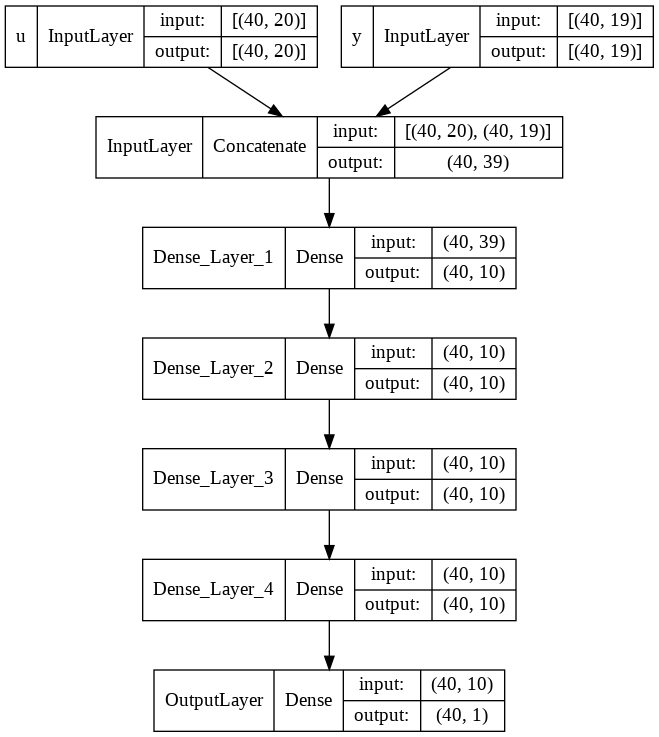

In [17]:
# Number of previous inputs
K = 20
# Number of previous outputs
H = 20

# Number of layers
L = 4
# Units per layer
A = [10, 10, 10, 10]

train_batch_size = n_train_signals * seq_per_signal

u = tf.keras.layers.Input(shape=(K), batch_size=train_batch_size, name='u')
y = tf.keras.layers.Input(shape=(H-1), batch_size=train_batch_size, name='y')

concatenate = tf.keras.layers.concatenate([u, y], name='InputLayer', axis=-1)

for i in range(L):
    if i == 0:
        layer = tf.keras.layers.Dense(units=A[i], 
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(concatenate)
    else:
        layer = tf.keras.layers.Dense(units=A[i],
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(layer)

outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(layer)

model = tf.keras.Model(inputs=[u, y], outputs=outputs, name='NARX')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError(), tf.metrics.RootMeanSquaredError()]

In [19]:
# Compile Model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

### Batch Training:
(`n_train_signals × seq_per_signal` sequences per batch, with `seq_per_signal` sequences for each frequency)

*Series-Parallel Architecture Training*: K input values and (H - 1) output values are used to predict the next output value

In [20]:
# Training over all the dataset:

# Setting the number of training epochs
num_epochs = 10
# Setting the number of steps per each epoch
steps_per_epoch = 20000

model.fit(train_data, epochs=num_epochs, steps_per_epoch=steps_per_epoch)

Epoch 1/10
20000/20000 [==============================] - 337s 9ms/step - loss: 9.1680e-05 - mean_absolute_error: 0.0055 - root_mean_squared_error: 0.0096
Epoch 2/10
20000/20000 [==============================] - 193s 10ms/step - loss: 1.3594e-05 - mean_absolute_error: 0.0028 - root_mean_squared_error: 0.0037
Epoch 3/10
20000/20000 [==============================] - 236s 12ms/step - loss: 1.0606e-05 - mean_absolute_error: 0.0025 - root_mean_squared_error: 0.0033
Epoch 4/10
20000/20000 [==============================] - 192s 10ms/step - loss: 9.1321e-06 - mean_absolute_error: 0.0023 - root_mean_squared_error: 0.0030
Epoch 5/10
20000/20000 [==============================] - 317s 16ms/step - loss: 8.4548e-06 - mean_absolute_error: 0.0022 - root_mean_squared_error: 0.0029
Epoch 6/10
20000/20000 [==============================] - 199s 10ms/step - loss: 7.6352e-06 - mean_absolute_error: 0.0021 - root_mean_squared_error: 0.0028
Epoch 7/10
20000/20000 [==============================] - 170s 9m

## Save the Model Weights

Set the model's name and save it

In [21]:
filename = f'NARX_seq_len={seq_len}_num_epochs={num_epochs}.h5'

# Saving the model weights
model.save_weights(filename, save_format='h5')

files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Prediction Model:

Model: "NARX"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u (InputLayer)                 [(1, 20)]            0           []                               
                                                                                                  
 y (InputLayer)                 [(1, 19)]            0           []                               
                                                                                                  
 InputLayer (Concatenate)       (1, 39)              0           ['u[0][0]',                      
                                                                  'y[0][0]']                      
                                                                                                  
 Dense_Layer_1 (Dense)          (1, 10)              400         ['InputLayer[0][0]']          

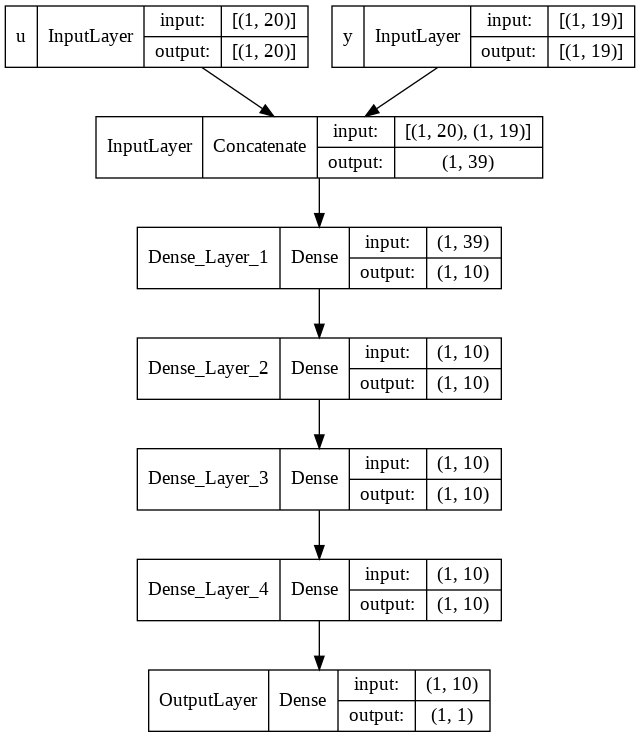

In [22]:
# Number of previous inputs
K = 20
# Number of previous outputs
H = 20

# Number of layers
L = 4
# Units per layer
A = [10, 10, 10, 10]

pred_batch_size = 1

u = tf.keras.layers.Input(shape=(K), batch_size=pred_batch_size, name='u')
y = tf.keras.layers.Input(shape=(H-1), batch_size=pred_batch_size, name='y')

concatenate = tf.keras.layers.concatenate([u, y], name='InputLayer', axis=-1)

for i in range(L):
    if i == 0:
        layer = tf.keras.layers.Dense(units=A[i],
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(concatenate)
    else:
        layer = tf.keras.layers.Dense(units=A[i],
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(layer)

outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(layer)

prediction_model = tf.keras.Model(inputs=[u, y], outputs=outputs, name='NARX')
prediction_model.summary()


tf.keras.utils.plot_model(prediction_model, show_shapes=True)

Take the weights from the just trained model:

In [23]:
prediction_model.load_weights(filename, by_name=False, skip_mismatch=False)

The following method is used to plot model predictions vs. ground truth, with some additional metrics as MSE and MAE.

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.offsetbox import AnchoredText

def plot_prediction(prediction, ground_truth, input_signal, frequency):

    MSE = mean_squared_error(y_true=ground_truth, y_pred=prediction)
    MAE = mean_absolute_error(y_true=ground_truth, y_pred=prediction)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(frequency)

    ax1.set_title('Prediction')
    ax1.scatter(input_signal, prediction)
    ax1.grid(True)
    anchored_text = AnchoredText('MSE:' + str(round(MSE, 6)) + '\n' + 'MAE:' + str(round(MAE, 6)), loc=2)
    ax1.add_artist(anchored_text)

    ax2.set_title('Ground Truth')
    ax2.scatter(input_signal, ground_truth, c='orange')
    ax2.grid(True)

### *Parallel-Series* Architecture Prediction (Open Loop):

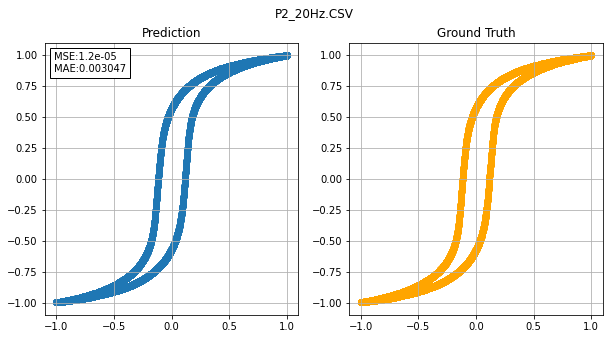

In [25]:
predictions = prediction_model.predict(val_data)

plot_prediction(predictions, val_dataset['P2_20Hz.CSV']['B'][seq_len - 1:], val_dataset['P2_20Hz.CSV']['H'][seq_len - 1:], 'P2_20Hz.CSV')

### *Parallel* Architecture Prediction (Close Loop):

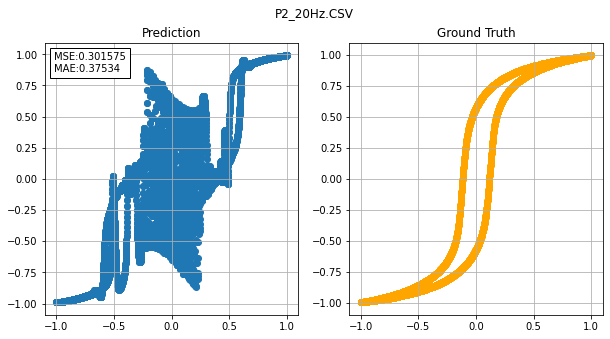

In [26]:
############# DEBUG ###############
## PREDICTIONS OVER VALIDATION DATA #

# Instantiating the Network Input Delay Lines
u = np.zeros((K, 1))
y = np.zeros((H - 1, 1))

# Testing the model on the validation data, to have an idea of what it is learning
model_predictions = {}
y_pred = []

for freq in val_dataset:
    x_signal = np.array(val_dataset[freq][['H']])
    y_true = np.array(val_dataset[freq][['B']])

    u = x_signal[:K]
    y = y_true[:H - 1]

    for i in range(K, len(x_signal)):
        prediction = prediction_model.predict([np.expand_dims(u, axis=0), np.expand_dims(y, axis=0)])

        # Rotating the circular buffers after each prediction
        u = np.roll(u, -1)
        u[-1] = x_signal[i]

        y = np.roll(y, -1)
        y[-1] = prediction

        y_pred.append(prediction)
        
    # Reshape batch predictions into a single array
    y_pred = np.array(y_pred).reshape(-1, 1)

    # Store predictions into a dict to be written as a file
    model_predictions[freq] = y_pred.tolist()
    
    plot_prediction(y_pred, y_true[seq_len:], x_signal[seq_len:], freq)